# Preprocessing input images and annotations

In [1]:
%matplotlib inline

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib 
import random
import scipy.stats
import shutil

import skimage.filters
import skimage.io
import skimage.segmentation

import utils.data_augmentation
import utils.data_split
import warnings

from tqdm import tqdm

# Parameters

In [2]:
# assume a nucleus is at least 10 by 10 pixels big
min_nucleus_size = 25

# Transform gray scale TIF images to PNG
transform_images_to_PNG = True

# Pixels of the boundary (min 2 pixels)
boundary_size = 2

In [3]:
# general
dir_root = '/data1/image-segmentation/BBBC022/'

# raw data
dir_raw_images = dir_root + 'raw_images/'
dir_raw_annotations = dir_root + 'new_renamed_annotations/'

# Split files
create_split_files = False

path_files_training = dir_root + 'training.txt'
path_files_validation = dir_root + 'validation.txt'
path_files_test = dir_root + 'test.txt'

# Maximum number of training images (0 for all)
max_training_images = 10

if create_split_files:
    file_list = os.listdir(dir_raw_images)

    [list_training, list_test, list_validation] = utils.data_split.create_image_lists(dir_raw_images,.5,.25)

    utils.data_split.write_path_files(path_files_training, list_training)
    utils.data_split.write_path_files(path_files_test, list_test)
    utils.data_split.write_path_files(path_files_validation, list_validation)

In [4]:
# Output directories

## split folders
dir_training = dir_root + 'unet/augmented_10/training/'
dir_validation = dir_root + 'unet/augmented_10/validation/'
dir_test = dir_root + 'unet/augmented_10/test/'

## boundary output
dir_boundary_labels = dir_root + 'unet/y_augm_10/'

## input data, normalized and 8 bit
dir_images_normalized_8bit = dir_root + 'unet/x_augm_10/'

# Create directories
os.makedirs(dir_training, exist_ok=True)
os.makedirs(dir_validation, exist_ok=True)
os.makedirs(dir_test, exist_ok=True)
os.makedirs(dir_boundary_labels, exist_ok=True)
os.makedirs(dir_images_normalized_8bit, exist_ok=True)

In [5]:
# Data Augmentation options (using elastic deformation)

# augmentation taks lots of times but only has to be computed once 
augment_images =  True

# augmentation parameters 
n_points = 16
distort = 5

# number of augmented images
n_augmentations = 10

## Read data partitions
- To split up in training, validation and test sets

In [6]:
with open(path_files_training) as f:
    training_files = f.read().splitlines()
    if max_training_images > 0:
        random.shuffle(training_files)
        training_files = training_files[0:max_training_images]
with open(path_files_validation) as f:
    validation_files = f.read().splitlines()
with open(path_files_test) as f:
    test_files = f.read().splitlines()

## Create Output Targets: Three Class Boundary

  0%|          | 0/200 [00:00<?, ?it/s]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
 34%|███▎      | 67/200 [00:04<00:08, 15.02it/s]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 68%|██████▊   | 137/200 [00:09<00:04, 14.53it/s]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 72%|███████▎  | 145/200 [00:09<00:03, 14.57it/s]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-se

int64 (520, 696)


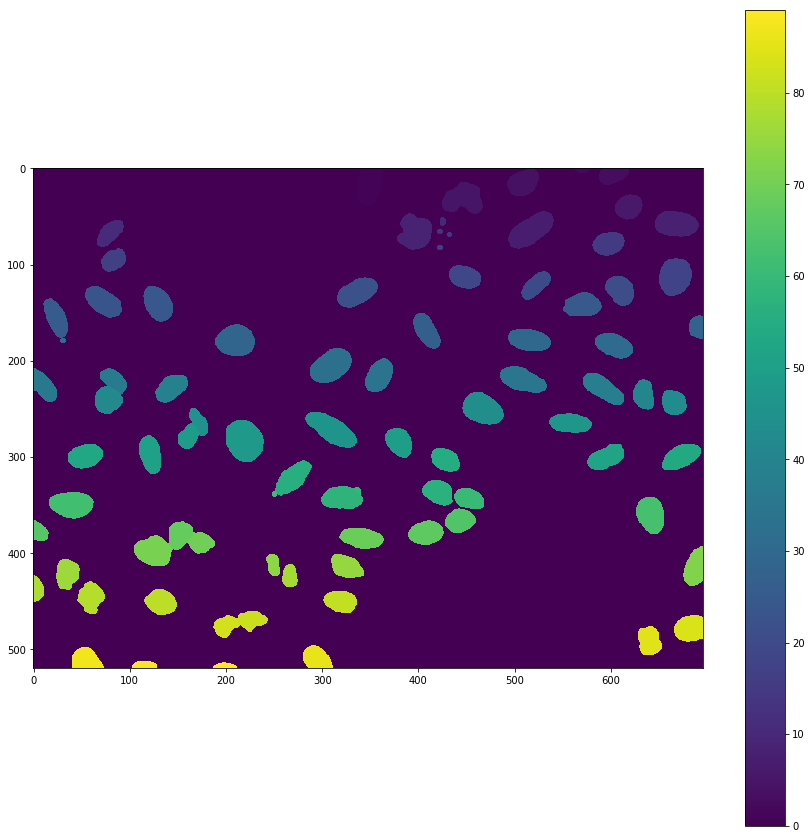

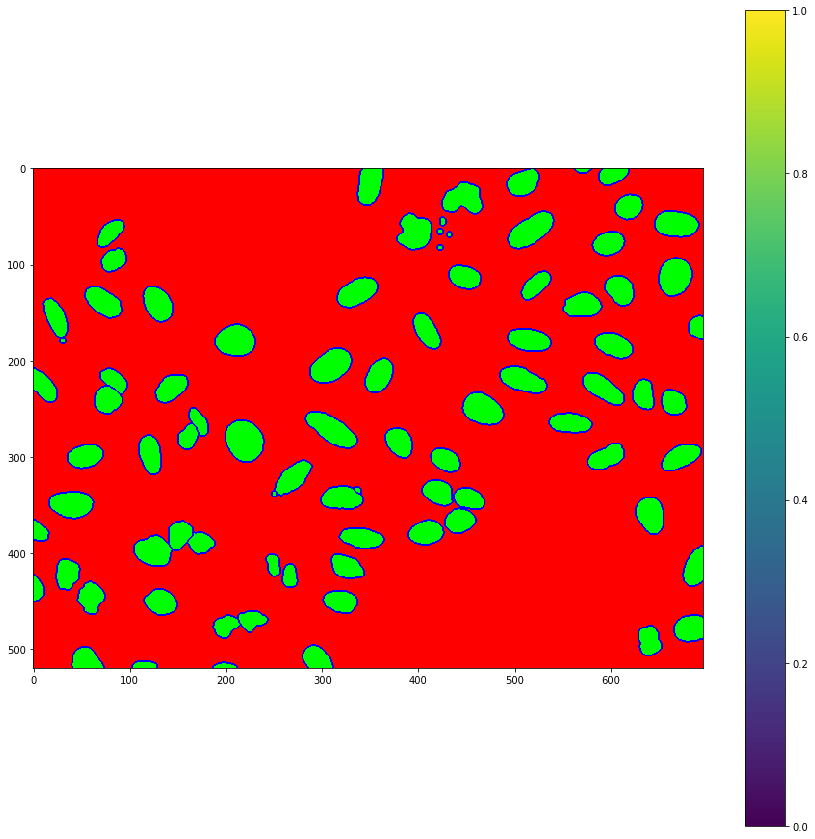

In [7]:
filelist = sorted(os.listdir(dir_raw_annotations))

# run over all raw images
for filename in tqdm(filelist):
    
    # GET ANNOTATION
    annot = skimage.io.imread(dir_raw_annotations + filename)
    
    # strip the first channel
    if len(annot.shape) == 3:
        annot = annot[:,:,0]
    
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=min_nucleus_size)
    
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)

    for k in range(2, boundary_size, 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # BINARY LABEL
    
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))
    
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1
    label_binary[boundaries == 1, 2] = 1
    
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(dir_boundary_labels + filename, label_binary)
    

# Show example image 
print(annot.dtype, annot.shape)

# plot original annotation
plt.figure(figsize=(15,15))
plt.imshow(annot)
plt.colorbar()
plt.show()

# plot boundary labels
plt.figure(figsize=(15,15))
plt.imshow(label_binary)
plt.colorbar()
plt.show()

## Image Preprocessing

  0%|          | 0/200 [00:00<?, ?it/s]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 200/200 [00:21<00:00,  9.45it/s]


BEFORE
uint8 (520, 696)


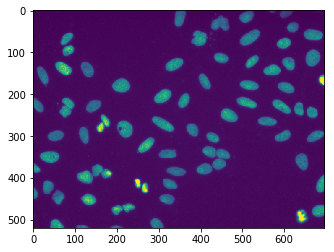

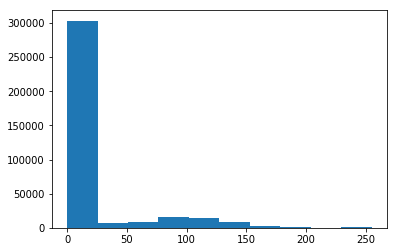

AFTER
uint8 (520, 696)


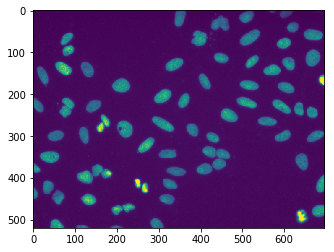

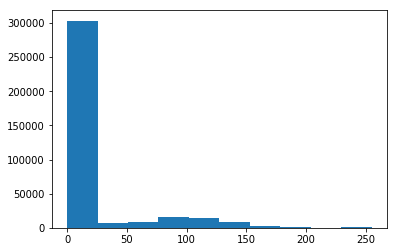

In [8]:
if transform_images_to_PNG:

    filelist = sorted(os.listdir(dir_raw_images))

    # run over all raw images
    for filename in tqdm(filelist):

        # load image and its annotation
        orig_img = skimage.io.imread(dir_raw_images + filename)       

        # IMAGE

        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(dir_images_normalized_8bit + filename[:-3] + 'png', img)

    # Show example image
    print("BEFORE")
    print(img.dtype, img.shape)
    plt.imshow(img)
    plt.show()
    plt.hist(img.flatten())
    plt.show() 
        
    print("AFTER")
    print(img.dtype, img.shape)
    plt.imshow(img)
    plt.show()
    plt.hist(img.flatten())
    plt.show()
    
else:
    dir_images_normalized_8bit = dir_raw_images

# Augment images (optional) 
* data augmentation using affine transformations 
* n_points x n_points data points are equally distributed in the image 
* distort 
* n_augmentations images are calculated for each image 


In [9]:
def generate_augmented_examples(filelist, n_augmentations, n_points, distort, dir_boundary_labels, dir_images_normalized_8bit):
    
    updated_filelist = []
    
    # run over all raw images
    for filename in tqdm(filelist):
            
        # check if boundary labels were calculated 
        my_file = pathlib.Path(dir_boundary_labels + filename)
        
        if my_file.is_file():
            
            # load image 
            x = skimage.io.imread(dir_images_normalized_8bit + filename)
            # load annotation 
            y = skimage.io.imread(dir_boundary_labels + filename)
            
            for n in range(1,n_augmentations):
                # augment image and annotation 
                x_augmented, y_augmented = utils.data_augmentation.deform(x, y, points = n_points, distort = distort)
                # filename for augmented images
                filename_augmented = os.path.splitext(filename)[0] + '_aug_{:03d}'.format(n) + os.path.splitext(filename)[1]
                skimage.io.imsave(dir_images_normalized_8bit + filename_augmented, x)
                skimage.io.imsave(dir_boundary_labels + filename_augmented, y)
                updated_filelist.append(filename_augmented)
                
    return filelist + updated_filelist 

if augment_images:
    training_files = generate_augmented_examples(training_files, n_augmentations, n_points, distort, dir_boundary_labels, dir_images_normalized_8bit)


 40%|████      | 4/10 [01:33<02:20, 23.46s/it]/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174_aug_001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174_aug_002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174_aug_003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/0x00b1/com/github/scikit-image/scikit-image/skimage/io/_io.py:134: UserWarning: /data1/image-segmentation/BBBC022/unet/y_augm_10/IXMtest_L

## Split data
- Split up in training, validation and test sets

In [10]:
# Add a 0 suffix because Keras thinks everything is a classification task organized in directories.

os.makedirs(dir_training + 'x/', exist_ok=True)
os.makedirs(dir_validation + 'x/0/', exist_ok=True)
os.makedirs(dir_test + 'x/0/', exist_ok=True)

os.makedirs(dir_training + 'y/', exist_ok=True)
os.makedirs(dir_validation + 'y/0/', exist_ok=True)
os.makedirs(dir_test + 'y/0/', exist_ok=True)

for filename in training_files:
    shutil.copyfile(dir_images_normalized_8bit + filename, dir_training + 'x/' + filename)
    shutil.copyfile(dir_boundary_labels + filename, dir_training + 'y/' + filename)
    
for filename in validation_files:
    shutil.copyfile(dir_images_normalized_8bit + filename, dir_validation + 'x/0/' + filename)
    shutil.copyfile(dir_boundary_labels + filename, dir_validation + 'y/0/' + filename)
    
for filename in test_files:
    shutil.copyfile(dir_images_normalized_8bit + filename, dir_test + 'x/0/' + filename)
    shutil.copyfile(dir_boundary_labels + filename, dir_test + 'y/0/' + filename)